## Lauren Ponsonby : Regime based Asset Allocation, back test for period of 2 years versus                                            SWIX

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
from datetime import datetime
import scipy.optimize as optimize

np.random.seed(123)

## Importing Data

In [361]:
stock = pd.read_csv('Merge2.csv')
len(stock['Dollar/Rand '])

104

## Identifies the 20 stocks least sensitive to the supplied time series, e.g Dollar/Rand or SWIX INDEX

In [175]:
non_buyable = ['SA Volatility Index ', 'Dollar/Rand ', 'SWIX INDEX ']
def initial_basket(against):
    least_sensitive = stock.corr()[against].abs().sort_values(ascending=True)
    basket = {}
    idx = 0
    while len(basket) < 20:
        possible_stock = least_sensitive.index.values[idx]
        idx += 1
        if not (possible_stock in non_buyable):
            basket[possible_stock] = 1/20.0
    return basket

### Below identifies the 20 stocks least sensitive to Dollar/Rand fluctuations

In [311]:
least_sensitive = stock.corr()['Dollar/Rand '].abs().sort_values(ascending=True)
least_sensitive.to_frame(name=None)

,Dollar/Rand
Vodacom,0.013018
Fortress B,0.071856
Truworths,0.104044
Redefine,0.267240
Mr Price,0.291425
MTN Group,0.292732
Spar,0.313742
SWIX INDEX,0.323950
Old mutual,0.358553
Sasol,0.403191


### Below I have created an initial portfolio with equal weightings

In [307]:
pd.DataFrame(list(initial_basket('SA Volatility Index ').items()), columns=['Stock', 'Initial Weighting'])

,Stock,Initial Weighting
0,Vodacom,0.05
1,British American,0.05
2,Mr Price,0.05
3,Barclays,0.05
4,Sasol,0.05
5,Growthpoint,0.05
6,Truworths,0.05
7,MTN Group,0.05
8,Fortress B,0.05
9,Old mutual,0.05


## Below is the function that takes a weighting and buys stock on a best effort basis
- "Best Effort" being the sometime some cash might be uninvestable, because occasionally we will have too little cash left over

In [318]:
def buy_stocks(wt, money, date_as_idx, cost=1):
    portfolio = {}
    cash = 0
    for stockname, stockwt in wt.items():
        money_to_spend = cost*money * stockwt
        price_at_t = stock[stockname][date_as_idx]
        vol = int(money_to_spend/price_at_t)
        cash += money_to_spend - vol*price_at_t
        portfolio[stockname] = vol
    portfolio['Cash'] = cash
    return portfolio

buy_stocks(basket, 1e8, 1)
pd.DataFrame(list(buy_stocks(basket, 1e8, 1).items()), columns = ['Stock' , 'Amount of Stocks Held'])

,Stock,Amount of Stocks Held
0,Vodacom,340.00
1,Fortress B,1545.00
2,Truworths,542.00
3,Redefine,4629.00
4,Mr Price,289.00
5,MTN Group,351.00
6,Spar,271.00
7,Old mutual,1276.00
8,Sasol,104.00
9,British American,56.00


### Below is liquidation value of the portfolio at the given time

In [162]:
def sell(wt, date_idx):
    cash = 0
    for name, vol in wt.items():
        if name == 'Cash':
            cash += vol
            continue
        price = stock[name][date_idx]
        cash += price*vol
    return cash

In [143]:
def re_weight(port, losers, winners, pct):
    updated = port.copy()
    loners = 0
    for loser in losers:
        if port[loser] <= 1e-7:
            break
        loners += 1
        updated[loser] -= pct
    nerds = 0
    for winner in winners:
        nerds += 1
        updated[winner] += pct
        if nerds == loners:
            break
    return updated

In [369]:
def fmt_rand(money):
    r = str(int(money/100.0))
    c = str(int(money) % 100)
    return "R" + r + "." + c

## Below is my trading algorithm 

In [372]:
class PortfolioTracker():
    def __init__(self, ip, ic, against='Dollar/Rand ', fee=0.98):
        self.portfolios = [ip]
        self.vals = [buy_stocks(ip, ic, 0, 0.9)]
        self.last_rebalance = 0
        self.moneys = [sell(self.vals[-1], 0)]
        self.against = against
        self.fee = fee
        self.descriptions = pd.DataFrame(columns=['Sold', 'Bought'])
        self.fd = pd.DataFrame(columns=['Portfolio Value at Rebalancing'])
        
    def mk_descript(self, losers, winners):
        desc = {}
        s = ", ".join(map(lambda x: x.rstrip(), losers))
        desc['Sold'] = s
        s = ", ".join(map(lambda x: x.rstrip(), winners))
        desc['Bought'] = s
        return desc
        
    def rebalance(self, time):
        if time - self.last_rebalance == 3:
            port = self.portfolios[-1]
            holdings = self.vals[-1]
            basket_and_dr = [self.against]
            basket_and_dr.extend(list(port.keys()))
            if 'Cash' in basket_and_dr:
                basket_and_dr.remove('Cash')
            changes = stock[basket_and_dr][self.last_rebalance:time].corr()[self.against].abs().sort_values(ascending=False)[1:]
            losers = changes.index.values[0:5]
            winners = changes.index.values[15:20]
            series = pd.Series(self.mk_descript(losers, winners))
            series.name = stock['Date '][time]
            self.descriptions = self.descriptions.append(series)
            #self.descriptions = self.descriptions.append(self.mk_descript(losers, winners), ignore_index=True)
            new_port = re_weight(port, losers, winners, 0.025)
            coh = self.fee*sell(holdings, time)
            self.moneys.append(coh)
            self.portfolios.append(new_port)
            self.vals.append(buy_stocks(new_port, coh, time, self.fee))
            self.last_rebalance = time
            series2 = pd.Series({'Portfolio Value at Rebalancing': fmt_rand(coh)})
            series2.name = stock['Date '][time]
            self.fd = self.fd.append(series2)
        

In [373]:
dr_basket = initial_basket('Dollar/Rand ')
p = PortfolioTracker(dr_basket, 1e8, 'Dollar/Rand ', 0.95)
amts = [1]
for i in range(0, 80):
    p.rebalance(i)
    amts.append(p.moneys[-1] / 1e8)

### Below is an audit trail of transactions with amounts redacted, as per 3 week rolling time period 

In [375]:
p.descriptions

,Sold,Bought
2016/03/18,"MTN Group, British American, Lifehealth, Barcl...","Naspers, Truworths, Mr Price, Fortress B, Sappi"
2016/04/08,"Vodacom, Mondi PLC, Mondi Ltd, Redefine, Sappi","Barclays, Lifehealth, Remgro, MTN Group, Mr Price"
2016/04/29,"MTN Group, Sasol, Vodacom, Lifehealth, Truworths","Mondi PLC, Redefine, Richemont, BidCorp, Aspen"
2016/05/20,"British American, Aspen, BidCorp, Truworths, O...","Barclays, Naspers, Richemont, Lifehealth, Spar"
2016/06/10,"Mondi Ltd, Mondi PLC, Spar, Richemont, Vodacom","Redefine, MTN Group, Old mutual, Aspen, Fortre..."
2016/07/01,"Fortress B, Truworths, Mondi Ltd, Redefine, Mo...","Aspen, Remgro, Mr Price, Spar, MTN Group"
2016/07/22,"Fortress B, BidCorp, Sappi, Spar, Naspers","Richemont, British American, Vodacom, Lifeheal..."
2016/08/12,"Mondi Ltd, Sasol, British American, Mondi PLC,...","BidCorp, Redefine, Aspen, Richemont, Lifehealth"
2016/09/02,"Sappi, Richemont, Barclays, Mondi Ltd, British...","Mr Price, Aspen, Vodacom, Old mutual, Fortress B"
2016/09/23,"Remgro, Old mutual, Mr Price, BidCorp, Naspers","Aspen, Mondi PLC, Sappi, Fortress B, MTN Group"


### Below is the changing portfolio value at each 3 week rolling timer interval

In [374]:
p.fd

,Portfolio Value at Rebalancing
2016/03/18,R914430.22
2016/04/08,R800997.31
2016/04/29,R747046.86
2016/05/20,R671737.40
2016/06/10,R621848.40
2016/07/01,R555717.48
2016/07/22,R511349.54
2016/08/12,R466538.96
2016/09/02,R455665.52
2016/09/23,R449540.13


## Next we have a graph depicting our proprietary regime's value (That exceeding the SWIX index)

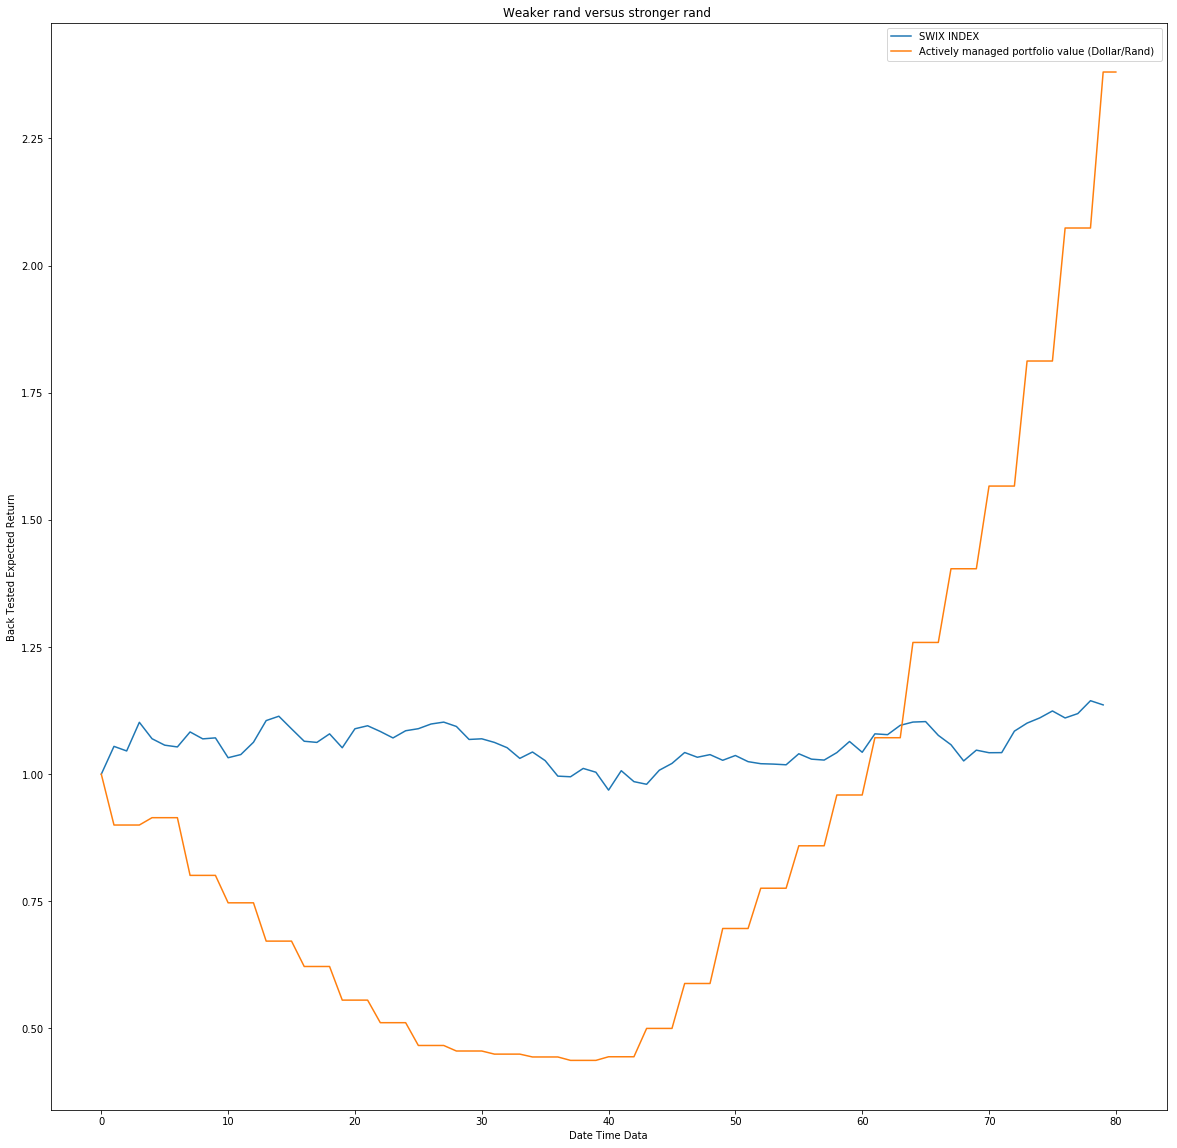

In [354]:
plt.figure(figsize=(20,20))
plt.plot(stock['SWIX INDEX '][:80]/stock['SWIX INDEX '][0])
plt.xlabel('Date Time Data')
plt.ylabel('Back Tested Expected Return')
plt.plot(amts, label='Actively managed portfolio value (Dollar/Rand) ')
plt.title('Weaker rand versus stronger rand ')
plt.legend(loc='best')

In [297]:
vol_basket = initial_basket('SA Volatility Index ')
p = PortfolioTracker(vol_basket, 1e8, 'SA Volatility Index ', 0.96)
vamts = [1]
for i in range(0, 60):
    p.rebalance(i)
    vamts.append(p.moneys[-1] / 1e8)

## Next we have a graph depicting our proprietary regime's value (That exceeding the SWIX index again) parametrized by volatitly index and not Dollar/Rand

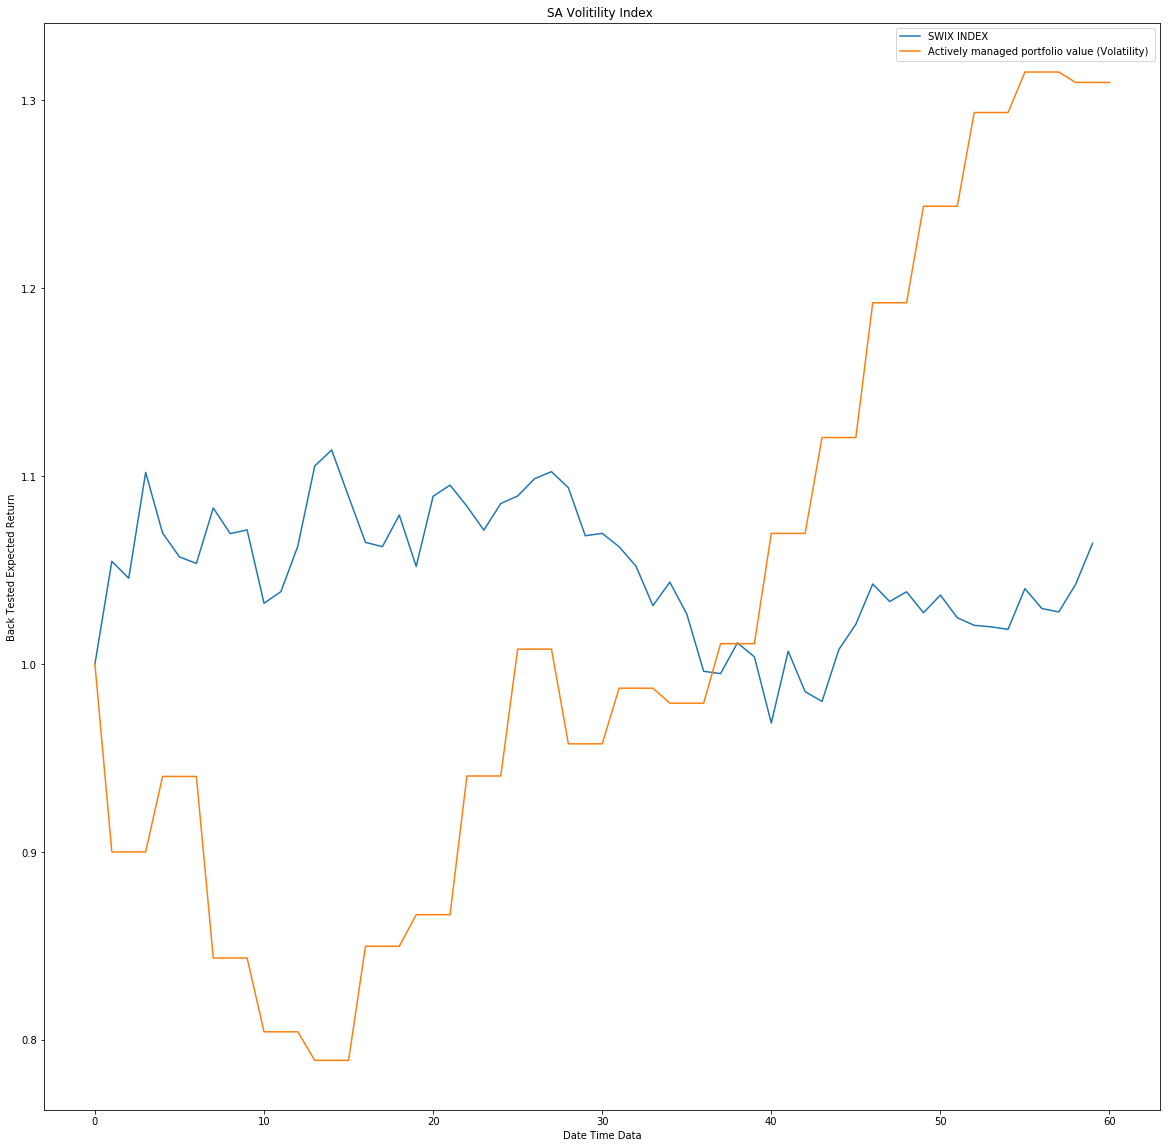

In [376]:
plt.figure(figsize=(20,20))
plt.plot(stock['SWIX INDEX '][:60]/stock['SWIX INDEX '][0])
plt.xlabel('Date Time Data')
plt.ylabel('Back Tested Expected Return')
plt.plot(vamts, label='Actively managed portfolio value (Volatility) ')
plt.title('SA Volitility Index ')
plt.legend(loc='best')

- As you can see, I have beaten the index with this algorithm.
- If I had more data avalible I would be able to refine this algorithm further, increasing our returns

### Lastly, I'd like to thank you for the opportunity and for your continued consideration for this role, I quite enjoy the challenge you have put forward :)